# SISTEMAS DE RECOMENDAÇÃO PARA USUÁRIO - Machine Learning

OBJETIVO: criar sistema de recomendação de filmes para usuário com base em seus históricos de ratings, interações e preferências disponíveis no dataset.

ETAPAS:
- carregamento de dataset contendo mais de 35000 avaliacoes de clientes sobre filmes assistidos.
- analise e visualizacao de informacoes relativas as visualizacoes e avaliacoes de filmes realizados por usuarios, tais como: numero de avaliacoes realizadas, media dos ratings concedidos aos filmes assistidos, etc. 
- com a biblioteca surprise, normalizacao dos dados e criacao de matriz com categorizacao de interacoes entre usuarios e os produtos consumidos por meio do algoritmo svd++. 
- aplicacao do algoritmo svd++ em dados faltantes, obtendo informacoes sobre produtos nao consumidos ainda por cada usuario e a previsao de ratings para tais produtos. 
- filtro das maiores previsoes de rating por usuario
- ajuste de parametros do modelo e verificacao da acuracia em novo teste 
- identificacao de filmes semelhantes atraves do algoritmo knn para sistema de recomendacao. 
- recomendacao: neste caso, escolhemos como parametro a semelhanca de caracteristicas entre filmes para recomendacao ao usuario e nao suas interacoes previas como criterios para detectar possiveis preferencias e realizar sugestoes. Esta estrategia foi adotada considerando a hipotese de um cenario em que ocorra 'cold start' (com usuarios novos e portanto sem historico previo para recomendacao).
No caso de um dataset com dados apenas de usuarios antigos e poucos dados missing, seria plausivel ajustar o parametro 'user based' como true, considerando assim apenas as interacoes previas dos clientes (e nao a semelhanca entre os produtos disponiveis) como principal criterio para recomendacoes de filmes.


* MÉTODOS e FILTRAGENS PRINCIPAIS PARA SE TRABALHAR COM SISTEMAS DE RECOMENDAÇÃO (podendo criar um método híbrido de recomendação):
1. Filtragem baseada em conteúdo (content based): traz recomendações com base nas características de um produto/serviço. Ex: recomendação de um filme para o usuário com base nas características dos filmes vistos anteriormente pelo mesmo. O lado negativo deste sistema é que ele pode se tornar uma 'bolha de recomendação': que só indica um mesmo produto/serviço de características muito semelhantes. Ex: indicação apenas de jogos após a compra de 2 jogos pelo usuário.

2. Filtragem colaborativa(collaborative filtering): traz recomendações com base no volume, interesse e interações dos usuários por determinados produtos/serviços, prevenindo a ocorrência da 'bolha de recomendação' já que nao leva em consideração apenas as preferências individuais de um usuário. Geralmente este método tem muito custo operacional e muitos dados missing.
    
3. Método 'cosine distance/similarity' (distancia do cosseno): verifica a semelhançaa entre dois vetores, podendo cada um destes vetores ser 'usuários', 'produtos/servicos', características de produtos, etc. Matematicamente falando, o algoritmo calcula o cosseno do ângulo entre vetores.
    
4. Método 'matrix factorization/svd++'(fatoração matricial/ 'single value decomposition'): cria uma matriz com todas as informações dos usuários, criando features categorizando produtos/serviços e as features de categorizaçã destes mesmos produtos/serviços pelos usuários. Este sistema lembra uma técnica de algebra linear para decomposiça e desdobramento de matrizes chamada 'single value decomposition'(svd).


<b>CRIANDO UM SISTEMA DE RECOMENDAÇÃO COM A BIBLIOTECA SURPRISE:

Instalar a biblioteca no prompt do Anaconda(pois nao e default do Anaconda) e importá-la:
* conda install -c conda-forge scikit-surprise
* pip install scikit-surprise

In [1]:
import surprise

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Carregando o dataset 'Ratings'(contem id usuario, id filmes e rating dos usuarios) e atribuindo nomes as colunas:
dados = pd.read_csv('ratings.txt', sep=" ", names=['id_usuario', 'id_filme', 'rating'])
dados

,id_usuario,id_filme,rating
0,1,1,2.0
1,1,2,4.0
2,1,3,3.5
3,1,4,3.0
4,1,5,4.0
...,...,...,...
35492,1508,84,3.5
35493,1508,17,4.0
35494,1508,669,1.0
35495,1508,686,2.5


<b>PROCESSANDO DATASET PARA SISTEMA DE RECOMENDAÇÃO

In [3]:
#Criando variaveis para entender e quantificar o dataset:
filmes = len(dados['id_filme'].unique())
usuarios = len(dados['id_usuario'].unique())
amostras = dados.shape

print('Qtde de filmes:', filmes)
print('Qtde de usuarios:', usuarios)
print('Qtde de avaliacoes:', amostras)

Qtde de filmes: 2071
Qtde de usuarios: 1508
Qtde de avaliacoes: (35497, 3)


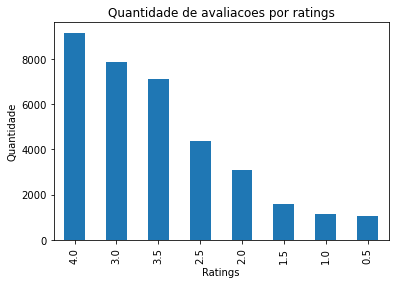

In [4]:
#Criando grafico de barras para visualizar quantidade de avaliacoes por usuario
dados['rating'].value_counts().plot(kind='bar', title='Quantidade de avaliacoes por ratings', 
                                    xlabel= 'Ratings', ylabel='Quantidade') 
plt.show()

In [5]:
#Calculando menores e maiores ratings com metodo 'min' e 'max' e Visualizando este range com ' format':
menor_rating = dados['rating'].min()
maior_rating = dados['rating'].max()
print('Variacao de ratings:{0} a {1}'.format(menor_rating, maior_rating))

Variacao de ratings:0.5 a 4.0


In [6]:
#Considerando que a escala default da biblioteca Surprise vai de 1 ate 5, temos que ajustar nossa escala de ranges entre 1 e 5:
escala = surprise.Reader(rating_scale=(0.5, 4.0))
ajusteDados = surprise.Dataset.load_from_df(dados, escala)  #criando ajuste de dataset com ratings 'normalizados' entre 1 e 5

In [7]:
#Criando variavel para o dataset com dados(ratings) ajustados:
dadosNovo = ajusteDados.build_full_trainset()

#Escolhendo e aplicando o algoritmo de recomendacao para o dataset:
modelo = surprise.SVDpp(n_factors=20)  #Algoritmoe scolhido: SVD++  #N_factors: numero de features que desejamos criar
modelo.fit(dadosNovo)

<b>CRIANDO PREVISOES DE RATINGS DE USUÁRIOS

In [8]:
#Criando novo dataset a partir de dados missing/nao informados pelos usuarios: 
dadosNulos = dadosNovo.build_anti_testset()

#Aplicando/testando algoritmo ja treinado em dados nulos: 
previsao = modelo.test(dadosNulos)  #combinando as relacoes possiveis entre usuario e features:

<b>CONSIDERAÇÕES SOBRE INFORMAÇÕES OBTIDAS ATÉ O MOMENTO:

* Vemos, por exemplo, que o algoritmo detectou que o usuario de 'id=1' interagiu com filmes até a 'id=12'. O 'id=13' corresponde aos dados nulos - neste caso, filmes não vistos pelo usuário 'id 1'.
* Est = previsao do rating/avaliaçã que o usuário de 'id=1' daria para este filme nulo 'id=13'.
* Logo, as previsões que temos até agora (segue abaixo) referem-se a nota que cada usuário daria para cada filme não visto(missing) listado no dataset.

In [9]:
previsao

[Prediction(uid=1, iid=13, r_ui=3.0028030537791928, est=3.4252150459171755, details={'was_impossible': False}),
 Prediction(uid=1, iid=14, r_ui=3.0028030537791928, est=2.9450305904852536, details={'was_impossible': False}),
 Prediction(uid=1, iid=15, r_ui=3.0028030537791928, est=3.1625792875765275, details={'was_impossible': False}),
 Prediction(uid=1, iid=16, r_ui=3.0028030537791928, est=3.387636785373153, details={'was_impossible': False}),
 Prediction(uid=1, iid=17, r_ui=3.0028030537791928, est=2.992753540741147, details={'was_impossible': False}),
 Prediction(uid=1, iid=18, r_ui=3.0028030537791928, est=3.41279867193102, details={'was_impossible': False}),
 Prediction(uid=1, iid=19, r_ui=3.0028030537791928, est=3.284270012108192, details={'was_impossible': False}),
 Prediction(uid=1, iid=20, r_ui=3.0028030537791928, est=3.1342310118421057, details={'was_impossible': False}),
 Prediction(uid=1, iid=21, r_ui=3.0028030537791928, est=3.0843993767155307, details={'was_impossible': False}

In [10]:
#Total de previsoes reunindo todas as combinacoes possiveis entre as features (ratings, usuario, filmes):
len(previsao)

3087574

In [29]:
#Medindo a acuracia da previsao calculando o erro(rmse):
from surprise import accuracy
accuracy.rmse(previsao) 

RMSE: 0.4070


0.40697963050240715

<b>APLICANDO MODELO DE PREVISÃO GERAL

In [60]:
#criando bases de treino e teste
from surprise.model_selection import train_test_split
dadosNovo_treino, dadosNovo_teste = train_test_split(ajusteDados, test_size=0.30)

#instanciando algoritmo de previsao e aplicando aos dados 
algoritmo = surprise.SVDpp(n_factors=20)
algoritmo.fit(dadosNovo_treino)
previsoes_gerais = algoritmo.test(dadosNovo_teste)

In [39]:
previsoes_gerais

[Prediction(uid=308, iid=743, r_ui=0.5, est=1.5842242247382772, details={'was_impossible': False}),
 Prediction(uid=1439, iid=216, r_ui=4.0, est=3.037143195923893, details={'was_impossible': False}),
 Prediction(uid=238, iid=17, r_ui=3.5, est=3.0797584902577184, details={'was_impossible': False}),
 Prediction(uid=848, iid=343, r_ui=4.0, est=3.580975589060604, details={'was_impossible': False}),
 Prediction(uid=929, iid=257, r_ui=0.5, est=2.3808522433684822, details={'was_impossible': False}),
 Prediction(uid=897, iid=1, r_ui=4.0, est=2.6755427251750867, details={'was_impossible': False}),
 Prediction(uid=203, iid=905, r_ui=2.0, est=2.9090859676337404, details={'was_impossible': False}),
 Prediction(uid=1499, iid=84, r_ui=4.0, est=3.201531898903878, details={'was_impossible': False}),
 Prediction(uid=198, iid=215, r_ui=3.5, est=3.2322804374723364, details={'was_impossible': False}),
 Prediction(uid=188, iid=819, r_ui=4.0, est=2.976846863109305, details={'was_impossible': False}),
 Predi

In [40]:
#Acuracia das previsoes do modelo:
from surprise import accuracy
accuracy.rmse(previsoes_gerais) 

RMSE: 0.8061


0.8061063837156813

<b>APLICANDO PREVISÃO DE USUÁRIO ESPECÍFICO

In [41]:
#Fazendo apenas previsoes por usuario e filme especifico:
previsao_usuario = modelo.predict(uid='30', iid='87')
rating = previsao_usuario.est
print('Previsao de rating do usuario id=30 para o filme id=87:', rating)

Previsao de rating do usuario id=30 para o filme id=87: 3.0028030537791928


<b>AJUSTANDO OS PARÂMETROS DO MODELO:IDENTIFICANDO MELHOR LEARNING RATE e RMSE PARA O ALGORITMO

In [55]:
#Ajustando parametros do modelo: criando o GridSearcjCV com a  billioteca Surprise 
param_grid = {'lr_all': [.007, .01, 0.05, 0.001], 'reg_all': [0.02, 0.1, 1.0, 0.005]}
#valor default lr_all(learning rate): .007 #reg_all(peso de regularizacao)
                                                 
surpriseGrid = surprise.model_selection.GridSearchCV(surprise.SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
surpriseGrid.fit(ajusteDados)
print(surpriseGrid.best_params['rmse'])

{'lr_all': 0.007, 'reg_all': 0.1}


<b>CRIANDO SISTEMA DE RECOMENDACAO POR SEMELHANCA DE CARACTERISTICAS DE PRODUTOS

In [47]:
#Instanciando e aplicando o modelo para recomendacao:
from surprise import KNNBasic

dataKNN = ajusteDados.build_full_trainset()
algoKNN = KNNBasic(sim_options={'name': 'cosine', 'user_based': False}) 
#name: algoritmo de similaridade. Informamos para encontrar vizinhos mais proximos usando 'cosine'(distancia cosceno)
#user_based==True: calcula a similaridade entre usuarios. False: calcula similaridade entre outras features (filmes, neste caso)

algoKNN.fit(dataKNN)

#Mostrando vizinhos mais proximos(filmes similares aos da id especificada abaixo):
vizinhos = algoKNN.get_neighbors(343, k=10) #quantidade de filmes similares ao de 'id=343', k=numero de filmes similares

print('10 sugestoes semelhantes ao filme id=343:', vizinhos)

Computing the cosine similarity matrix...
Done computing similarity matrix.
10 sugestoes semelhantes ao filme id=343: [58, 90, 102, 126, 147, 159, 168, 171, 193, 236]


<b>IDENTIFICANDO MELHORES ESTIMATIVAS POR USUARIO OBTIDAS ATE AGORA PELO ALGORITMO

In [61]:
#Criando uma funcao que retorna as Top-N recomendacoes para cada usuario. Esta funcao ira retornar um dicionario onde as chaves
#sao os usuarios e os valores sao listas de tuplas(filme, previsao, etc).

from collections import defaultdict
def top_previsoes(previsao, n=5):
    top_n = defaultdict(list)  #cria um dicionario onde os valores sao listas vazias
    for usuario, filme, _, predicao, _ in previsao:  # _ exclui a respectiva feature da analise
        top_n[usuario].append((filme, predicao))  #adiciona os pares de chave: valor ao dicionario
    for usuario, previsoes_usuario in top_n.items():
        previsoes_usuario.sort(key=lambda x: x[1], reverse=True) #classifica ratins do maior para o menor
        top_n[usuario] = previsoes_usuario[:n]  #compila apenas os primeiros valores
    return top_n

In [62]:
dicio = defaultdict(list)
dicio[0]

[]

In [63]:
#Criando variavel das top 5 primeiras previsoes instanciando a funcao criada:
top_5 = top_previsoes(previsao, n=5)
top_5

defaultdict(list,
            {1: [(335, 4.0),
              (286, 3.976624749221656),
              (675, 3.9451374022606363),
              (446, 3.8701059897268353),
              (805, 3.868429003667079)],
             2: [(805, 3.6077965487961565),
              (286, 3.5447080746676263),
              (335, 3.5006982631683354),
              (363, 3.490083535376981),
              (689, 3.4424768330834454)],
             3: [(2, 4.0),
              (278, 4.0),
              (286, 4.0),
              (5, 3.952471083588176),
              (215, 3.897309808174975)],
             4: [(286, 3.3256717501090316),
              (335, 3.308539556202201),
              (805, 3.3049667285868156),
              (728, 3.277316647300607),
              (363, 3.2682355941817636)],
             5: [(286, 3.743439003808598),
              (335, 3.7246296919780004),
              (658, 3.707967626766957),
              (805, 3.65171411560148),
              (363, 3.6336104373670195)],
            

In [64]:
#Filtranto apenas as 5 maiores previsoes por usuario:
for usuario, previsoes_usuario in top_5.items():
    print(usuario, [filme for(filme, _) in previsoes_usuario])

1 [335, 286, 675, 446, 805]
2 [805, 286, 335, 363, 689]
3 [2, 278, 286, 5, 215]
4 [286, 335, 805, 728, 363]
5 [286, 335, 658, 805, 363]
6 [286, 335, 805, 318, 675]
7 [335, 286, 675, 805, 728]
8 [286, 335, 805, 705, 307]
9 [286, 335, 689, 318, 658]
10 [286, 318, 805, 335, 689]
11 [286, 335, 728, 805, 658]
12 [286, 335, 675, 293, 696]
13 [286, 236, 446, 805, 689]
14 [805, 286, 511, 705, 189]
15 [286, 805, 335, 318, 728]
16 [286, 335, 675, 728, 805]
17 [335, 805, 286, 307, 728]
18 [286, 805, 335, 705, 363]
19 [286, 335, 318, 363, 689]
20 [805, 286, 335, 675, 363]
21 [68, 69, 126, 187, 189]
22 [5, 126, 189, 197, 218]
23 [805, 335, 286, 675, 363]
24 [335, 286, 805, 728, 363]
25 [286, 335, 675, 689, 728]
26 [335, 286, 675, 805, 363]
27 [335, 675, 728, 286, 658]
28 [335, 805, 286, 363, 728]
29 [250, 211, 335, 1091, 68]
30 [335, 805, 675, 728, 286]
31 [286, 335, 675, 805, 705]
32 [286, 805, 335, 363, 299]
33 [675, 335, 805, 286, 689]
34 [286, 335, 805, 705, 446]
35 [805, 335, 286, 363, 307]
36

732 [805, 286, 363, 675, 189]
733 [286, 805, 335, 307, 728]
734 [286, 335, 805, 218, 728]
735 [286, 675, 446, 414, 307]
736 [335, 286, 728, 805, 770]
737 [286, 335, 675, 318, 728]
738 [286, 805, 335, 318, 675]
739 [286, 335, 805, 689, 705]
740 [52, 68, 96, 126, 144]
741 [805, 363, 335, 286, 318]
742 [286, 335, 658, 307, 728]
743 [189, 218, 242, 286, 318]
744 [286, 335, 805, 705, 675]
745 [286, 335, 675, 805, 689]
746 [286, 805, 189, 705, 363]
747 [286, 335, 675, 307, 805]
748 [286, 335, 805, 728, 675]
749 [335, 675, 286, 728, 363]
750 [286, 335, 728, 365, 563]
751 [286, 805, 675, 335, 363]
752 [286, 363, 805, 335, 242]
753 [286, 335, 805, 705, 675]
754 [286, 335, 363, 805, 347]
755 [675, 286, 335, 805, 689]
756 [805, 286, 335, 363, 307]
757 [335, 286, 728, 805, 307]
758 [218, 286, 293, 307, 335]
759 [286, 805, 705, 335, 318]
760 [335, 286, 728, 675, 689]
761 [286, 335, 805, 347, 728]
762 [218, 242, 286, 307, 335]
763 [286, 335, 805, 728, 689]
764 [805, 335, 414, 702, 705]
765 [286, 363

1482 [286, 335, 805, 68, 572]
1483 [286, 335, 658, 805, 689]
1484 [335, 286, 675, 805, 307]
1485 [335, 414, 805, 286, 689]
1486 [286, 335, 218, 689, 728]
1487 [286, 805, 335, 307, 728]
1488 [286, 335, 728, 218, 68]
1489 [18, 24, 35, 43, 52]
1490 [335, 286, 728, 805, 563]
1491 [689, 805, 286, 446, 696]
1492 [126, 189, 218, 242, 286]
1493 [335, 689, 286, 728, 675]
1494 [2, 68, 197, 218, 286]
1495 [286, 805, 335, 728, 770]
1496 [286, 189, 705, 702, 211]
1497 [335, 286, 805, 728, 689]
1498 [286, 335, 658, 318, 728]
1499 [335, 347, 363, 286, 805]
1500 [286, 805, 335, 728, 705]
1501 [286, 335, 728, 805, 705]
1502 [805, 363, 286, 335, 675]
1503 [286, 805, 335, 318, 689]
1504 [805, 286, 363, 335, 728]
1505 [286, 689, 318, 425, 335]
1506 [286, 335, 434, 68, 728]
1507 [286, 805, 335, 705, 563]
1508 [805, 363, 242, 286, 414]


# FIM